In [1]:
import data
from utils import distances
import ETC
# from ETC.CCMC.pairs import ETC_causality, LZ_causality
import numpy as np


Loading ETC codebase ... Done
Loading LZ codebase ... Done


## Definitions:

Every song is represented as a dictionary with the following attributes:
- `melody`: this is an integer array that represents the distance(in semitones) of the notes used in the song from its key or tonic. As a result, we obtain a scale-invariant version of the song's melody.
    > Note: Since any song rarely spans more than three octaves, for most of the songs, the elements in this array will lie in the interval $[-12, 24]$. We denote rests with an integer value which is unlikely to be spanned in any song. In our case, we denote it by the index 99999. However, for ETC and distance metric calculations, the rests have been pruned out.
- `durations`: this array stores the durations of the occurring notes relative to the length of every measure of the beat. Hence, a **Quarter Note** corresponds to a value of $0.25$.
- `measure_onsets`: this array is just a positional encoder, which stores a value of $1$ for the first beat of every measure, and $0$ for other beats.
- `int_durations`: the elements of this array can be calculated as follows:
    \begin{align}
    int\_durations_i &= \lceil durations_i * 480 \rceil
    \end{align}
    Even though the smallest duration note found throughout all the songs was the sixteenth note, not all the notes that appear in the songs have a duration that corresponds to an inverse power of 2. They can be triplets, or fifth-notes etc. By using $480$ as the multiplier, we were able to convert all the durations into integer values.
- `adjusted_melody`: this array is basically every element of `melody`, repeated through the corresponding value of `int_durations`. This way, larger duration notes are proportionally repeated more times as compared to the smaller duration ones.

In [2]:
data.compute_adjusted_melody()
dicts = data.GetAll()
# print(compute_etc(dicts))




## Data Processing:

The `get_etc_modified_data()` method below performs the required pre-processing on the data. By default, it returns the `adjusted_melody`, but each element is incremented by $24$ and rests are represented by the number $200$. This way, data can be represented within the limits of the etc calculation algorithm.

If `num_bins` $ = 2$, then we bin the notes relative to the major 7$^{th}$ (which is equivalent to the _Pancham_ in Indian Art Music) into a total of $2$ bins. As this is a relative binning strategy, rests are ignored.

In [3]:
def get_etc_modified_data(dict, include_rests=True, num_bins=None):
    ret = []
    if num_bins != None:
        include_rests = False
    for ind in range(len(dict["adjusted_melody"])):
        if num_bins == 2 and dict["adjusted_melody"][ind] != 99999:
            if dict["adjusted_melody"][ind] > 7:
                ret.append(2)
            else:
                ret.append(1)
        elif include_rests:
            if dict["adjusted_melody"][ind]!= 99999:
                ret.append(dict["adjusted_melody"][ind] + 24)
            else:
                ret.append(200)
        else:
            if dict["adjusted_melody"][ind]!= 99999:
                ret.append(dict["adjusted_melody"][ind] + 24)

    return ret


print(get_etc_modified_data(data.AH_VOUS_ORIGINAL, num_bins=2))
print(get_etc_modified_data(data.AH_VOUS_ORIGINAL, include_rests=True))
print(get_etc_modified_data(data.AH_VOUS_ORIGINAL, include_rests=False))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

## Feature Extraction:

### Effort-To-Compress(ETC)

ETC effectively calculates the number of recursions of a lossless compression algorithm required for finding the optimum compressibility. Currently, the Non-Sequential Recursive Pair Substitution is being used as the lossless compression algorithm.

In [4]:
def compute_etc(dicts):
    etcs = []
    for dict in dicts:
        m_dict = get_etc_modified_data(dict, num_bins=2)
        etcs.append(ETC.compute_1D(m_dict, order=2, verbose=False, truncate=True)["ETC1D"])
    return etcs

compute_etc(dicts)

[22, 32, 32, 22, 29, 23, 34, 24, 24, 29]

### Distance Metrics

#### Longest Common Subsequence(LCS)

LCS, as the name suggests, is the length of the longest common subsequence between a pair of sequences. For example, consider string sequences `QUIVER` and `VERSION`. It is clear that the longest common subsequence between this pair of sequences is the subsequence `VER` and has a length 3. Naturally, LCS length invariant i.e. it doesn't matter if the sequences are of different lengths. LCS also follows the law of commutativity: $LCS(X, Y) = LCS(Y, X)$

In our experiments, LCS can help capture the longest continuous occurrence of a phrase in a pair of different melodies. LCS is primarily effective when `melody` is used instead of `adjusted_melody` in the data processing step.

#### Edit Distances(ED)

Edit Distance is the minimum number of edits required to make a pair of sequences equal to one another. For example, consider a pair of strings `TONIGHT` and `FORTNIGHT`. The edit distance is $3$ since $3$ 'edits' are required to convert the substring `TON` $\leftrightarrow$ `FORT`. The edit distance between the pair of strings `QUIVER` and `VERSION` will be $6$.

#### Hamming Distance(HD)

According to the documentation in `SciPy`:
> Hamming Distance is simply the proportion of disagreeing elements in a pair of sequences of the same length.

Hamming Distance can be calculated as:

\begin{align}
    HD(X, Y) &= \frac{\sum_{i = 1}^N (x_i \neq y_i)}{N}
\end{align}
where $N$ is the length of sequences $X$ and $Y$ and $x_i \in X$, $y_i \in Y$


#### ETC Distance($d_{ETC}$)

For computing the ETC distance ($d_{ETC}$) between a pair of sequences, the sequences are first concatenated, ETC is computed for both the concatenated and individual sequences, and then the average is calculated, as shown below:

\begin{align}
    d_{ETC}(X, Y) &= \frac{ETC(XY) + ETC(YX) - ETC(X) - ETC(Y)}{2}
\end{align}


In [5]:
def create_matrix_melody_distances(dict_list):
    LCSMatrix = np.zeros((len(dict_list), len(dict_list)))
    EDMatrix = np.zeros((len(dict_list), len(dict_list)))
    HDMatrix = np.zeros((len(dict_list), len(dict_list)))
    dETCMatrix = np.zeros((len(dict_list), len(dict_list)))
    Causility_Matrix = np.zeros((len(dict_list), len(dict_list)))
    for i in range(len(dict_list)):
        m_i = get_etc_modified_data(dict_list[i])
        for ii in range(len(dict_list)):
            m_ii = get_etc_modified_data(dict_list[ii])
            LCSMatrix[i][ii] = distances.LCSubSeq(m_i, m_ii, len(m_i), len(m_ii))
            EDMatrix[i][ii] = distances.editDist(m_i, m_ii, len(m_i), len(m_ii))
            HDMatrix[i][ii] = distances.hammingDist(m_i, m_ii, len(m_i), len(m_ii))
            dETCMatrix[i][ii] = distances.etcDist(m_i, m_ii)
            Causility_Matrix[i][ii] =  1 if ETC.CCM_causality(m_i, m_ii)['ETCE_cause'] == 'x' else 0

    return LCSMatrix, EDMatrix, HDMatrix, dETCMatrix, Causility_Matrix


[73, 106, 61, 80, 77, 55, 99]


<AxesSubplot:title={'center':'Edit Distances'}>

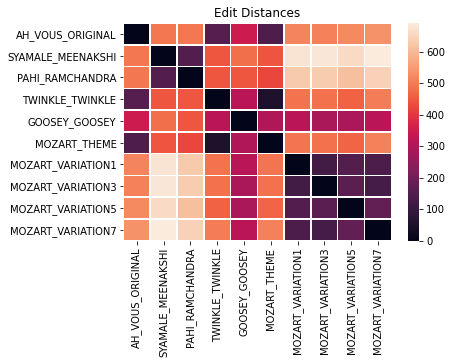

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

arrs = create_matrix_melody_distances(data.GetAll())
ax = plt.axes()
ax.set_title('Edit Distances')
sns.heatmap(arrs[1], linewidths=0.5, xticklabels=data.GetLabels(), yticklabels=data.GetLabels(), ax=ax)

# plt.imshow(arrs[0], interpolation='nearest', cmap='hot')
# plt.imshow(arrs[1])
# plt.imshow(arrs[2])
# plt.imshow(arrs[3])

<AxesSubplot:title={'center':'Hamming Distances'}>

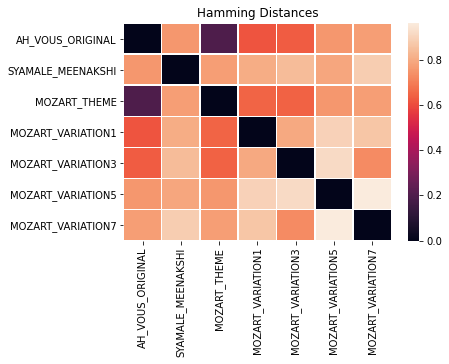

In [25]:
ax = plt.axes()
ax.set_title('Hamming Distances')
sns.heatmap(arrs[2], linewidths=0.5, xticklabels=data.GetLabels(), yticklabels=data.GetLabels(), ax=ax)

<AxesSubplot:title={'center':'ETC Distances'}>

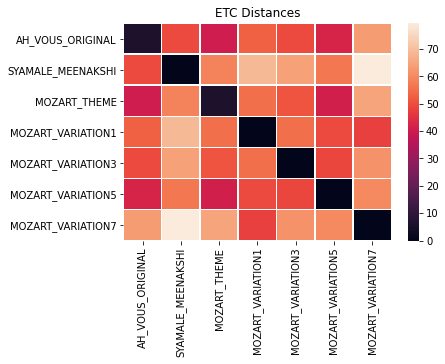

In [26]:
ax = plt.axes()
ax.set_title('ETC Distances')
sns.heatmap(arrs[3], linewidths=0.5, xticklabels=data.GetLabels(), yticklabels=data.GetLabels(), ax=ax)

In [18]:
import numpy as np

m1 = np.array(get_etc_modified_data(data.MOZART_THEME))
m2 = np.array(get_etc_modified_data(data.SYAMALE_MEENAKSHI))
# np.save("M1.npy", m1)
# np.save("M2.npy", m2)
ETC.CCM_causality(m1, m2, hashes=True)

{'x_hash': 'ab2859e7350ab3a6f613d556329f5aa5c5aeb922430907ef81fb8ba7a6f84af7',
 'y_hash': 'e00ab50016fda6bd7c2f90b2221e2f860aa205e62b510b1f67388004346fdbd9',
 'hash_algorithm': 'blake2b',
 'digest_size': 32,
 'length_x': 580,
 'length_y': 769,
 'ETC_x': 61,
 'ETC_y': 106,
 'ETC_x_given_Gy': 11,
 'ETC_y_given_Gx': 5,
 'length_x_residual': 217,
 'length_y_residual': 424,
 'ETC_x_residual': 50,
 'ETC_y_residual': 101,
 'ETC_x_residual_norm': 0.23148148148148148,
 'ETC_y_residual_norm': 0.23877068557919623,
 'ETCP_x_to_y': 0,
 'ETCP_y_to_x': 0,
 'ETCP_strength': 0,
 'ETCP_threshold': 1,
 'ETCP_direction': 'n_or_m',
 'ETCP_cause': 'n_or_m',
 'ETCE_x_to_y': 0.23877068557919623,
 'ETCE_y_to_x': 0.23148148148148148,
 'ETCE_strength': 0.0072892040977147465,
 'ETCE_tolerance': 0,
 'ETCE_direction': 'x_causes_y',
 'ETCE_cause': 'x',
 'LZ_x': 24,
 'LZ_y': 38,
 'LZ_xy': 58,
 'LZ_yx': 55,
 'LZ_concat_mean': 56.5,
 'LZ_concat_diff': 3,
 'LZP_x_to_y': 31,
 'LZP_y_to_x': 20,
 'LZP_strength': 11,
 'LZP_

<AxesSubplot:title={'center':'Causality'}>

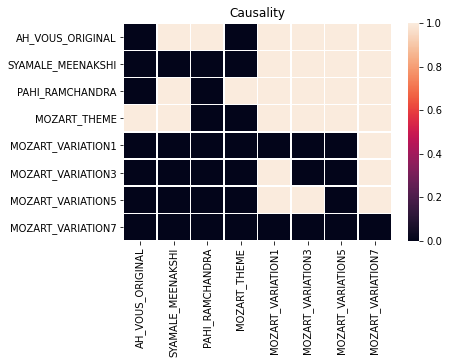

In [6]:
ax = plt.axes()
ax.set_title('Causality')
sns.heatmap(arrs[4], linewidths=0.5, xticklabels=data.GetLabels(), yticklabels=data.GetLabels(), ax=ax)